In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sms-spam-collection-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F483%2F982%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T081848Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6182aaaa8dfd836704a8cbe6029b9e3ffb8fd7c928f314570d5f45055bebef33e802fe34fa47a370554d2089d0ee14594cbab1465e5b4fa3f2a57b6bac5557b95e5018f25f0ee0f3a20c98630132d7bbc802d401b3eefe5370b8a90768f9923592cbf1ed85c1e113a7826f97a2ff0a5459ec71148ff19acb3aff02c04db33aa4cf954026a54dac102bb7781b5c0ecf26f771004336affc33d2d6b77f1a92313c4ac4bd1c3dfda8edd8ec15117e50a559f36992b38a8bd30dc8b10a5f2a6d030c48ae7adb8bfe1441f62d089ceef5bf848dc2ceadfe09545519928df44c2f7b46e42b669a787b3d358f7457da7aa27e755da636530278be621e166fa77e6be9b0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 215934 bytes downloaded
Downloaded and uncompressed: sms-spam-collection-dataset
Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


# Index
* Reading Csv File
* Removing unnecessary columns
* Classify The Emails
* Simplify The Data
* Train Test Split
* Converting Data into Integer
* Applying Logistic Regression
* Got 90% Accuracy

# Reading Csv File

In [4]:
df=pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv",encoding="latin-1")

In [5]:
df.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [6]:
df.shape

(5572, 5)

# Removing unnecessary columns

In [7]:
df=df.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [9]:
df.v1.value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

# Classify The Emails

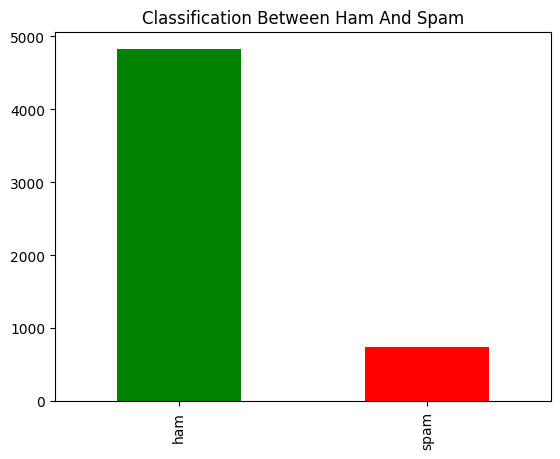

In [10]:
import matplotlib.pyplot as plt
df2=pd.value_counts(df["v1"])
df2.plot(kind="bar",color= ["green", "red"])
plt.title("Classification Between Ham And Spam")
plt.show()

In [11]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#  Simplify The Data

In [12]:
for i in range(0,5572):
    if df['v1'][i]=='spam':
        df['v1'][i]=1
    else:
        df['v1'][i]=0

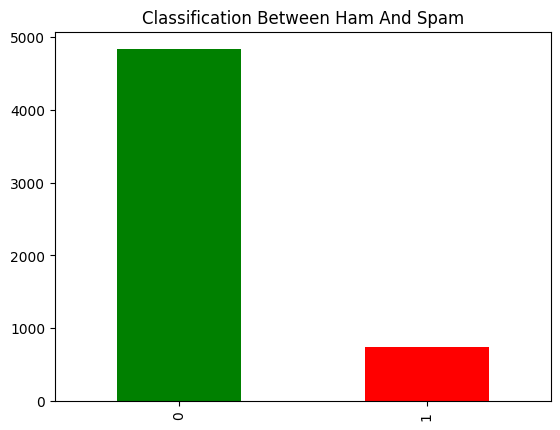

In [13]:
import matplotlib.pyplot as plt
df2=pd.value_counts(df["v1"])
df2.plot(kind="bar",color= ["green", "red"])
plt.title("Classification Between Ham And Spam")
plt.show()

# Train Test Split

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(df.v2, df.v1,test_size=0.3, random_state=42 )

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
cv= CountVectorizer()
x_train_new= cv.fit_transform(x_train)

In [16]:
y_test

3245    0
944     0
1044    1
2484    0
812     1
       ..
2505    0
2525    0
4975    0
650     0
4463    0
Name: v1, Length: 1672, dtype: object

In [17]:
x_train

708     To review and KEEP the fantastic Nokia N-Gage ...
4338                   Just got outta class gonna go gym.
5029    Is there coming friday is leave for pongal?do ...
4921    Hi Dear Call me its urgnt. I don't know whats ...
2592    My friend just got here and says he's upping h...
                              ...                        
3772    I came hostel. I m going to sleep. Plz call me...
5191                               Sorry, I'll call later
5226        Prabha..i'm soryda..realy..frm heart i'm sory
5390                           Nt joking seriously i told
860                   In work now. Going have in few min.
Name: v2, Length: 3900, dtype: object

In [18]:
y_train

708     1
4338    0
5029    0
4921    0
2592    0
       ..
3772    0
5191    0
5226    0
5390    0
860     0
Name: v1, Length: 3900, dtype: object

In [19]:
y_test

3245    0
944     0
1044    1
2484    0
812     1
       ..
2505    0
2525    0
4975    0
650     0
4463    0
Name: v1, Length: 1672, dtype: object

In [20]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Converting Data into Integer

In [21]:
y_train=y_train.astype(int)

In [22]:
x_train_new=x_train_new.astype(int)

In [ ]:
x_train_new

In [24]:
y_test=y_test.astype(int)

# Applying Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression()
lr.fit(x_train_new, y_train)
lr_pred= lr.predict(cv.transform(x_test))
lr_cm= confusion_matrix(y_test, lr_pred)

# Got 90% Accuracy

In [26]:
f1_score(y_test, lr_pred)

0.9090909090909092

**Thanks**